Дана база пассажиропотока в некотором аэропорту “Сайнс” с января 2007 г. по 2018 гг. в файле airport.csv

Необходимо написать модель для предсказания пассажиропотока и предсказать пассажиропоток в последующие 12 месяцев. Ответ выведите в формате JSON

Мерой точности построенной модели является MSE не более 520000.0 от реальных значений

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
%run pipeline.ipynb

In [2]:
df=pd.read_csv('datasets/airport.csv')
df.head()

,Passengers,Year,Month
0,1235.75,2007,4
1,1487.53,2007,3
2,1563.96,2007,7
3,1575.27,2007,0
4,1762.00,2007,8


In [3]:
pipe.info.getInfo(df)

,DataType,Values,Null,Missing Rate,Unique,Useless
Passengers,float64,145,12,7.64%,145,False
Year,int64,157,0,0.00%,14,False
Month,int64,157,0,0.00%,12,False


Сделаем нормальную дату

In [4]:
df['Day']=pd.Series(1, index=df.index)
df['Month']=df['Month']+1
df['date']=pd.to_datetime(df[['Year','Month','Day']],yearfirst=True)

In [7]:
df= df.sort_values(by='date').reset_index()
df.set_index('date', inplace=True)
df.drop(columns='index', inplace=True)
df

,Passengers,Year,Month,Day
date,,,,
2007-01-01,1575.27,2007,1,1
2007-02-01,1956.15,2007,2,1
2007-03-01,2365.56,2007,3,1
2007-04-01,1487.53,2007,4,1
2007-05-01,1235.75,2007,5,1
...,...,...,...,...
2019-09-01,NaN,2019,9,1
2019-10-01,NaN,2019,10,1
2019-11-01,NaN,2019,11,1


Уберем данные до 2019 года,т.к. они все равно пустые

In [8]:
df[df['Year']<2019].isnull().sum()

Passengers    0
Year          0
Month         0
Day           0
dtype: int64

In [15]:
df_2018=df[df['Year']<2019].copy()

Проверим индекс на непрерывность

In [10]:
df_2018.index.is_monotonic

True

In [16]:
df_2018 = df_2018[['Passengers']]
df_2018

,Passengers
date,
2007-01-01,1575.27
2007-02-01,1956.15
2007-03-01,2365.56
2007-04-01,1487.53
2007-05-01,1235.75
...,...
2018-08-01,5558.45
2018-09-01,4936.49
2018-10-01,4542.83


Посмотрим на график изменения пассажиропотока

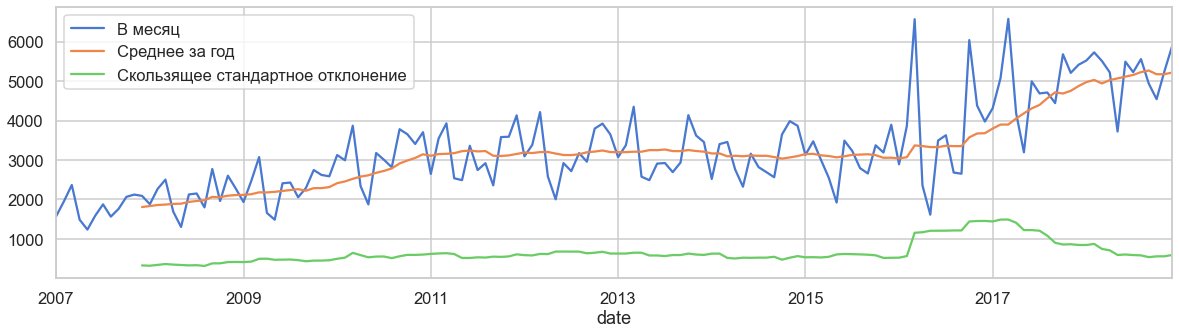

In [19]:
sns.set(context='talk', style='whitegrid', palette='muted')

plt.figure(figsize=(20, 5))

ax = df_2018.plot(ax=plt.gca())
df_2018.rolling(12).mean().plot(ax=ax)
df_2018.rolling(12).std().plot(ax=ax)
plt.legend(labels = ('В месяц', 'Среднее за год', 'Скользящее стандартное отклонение'))

Сделаем декомпозицию

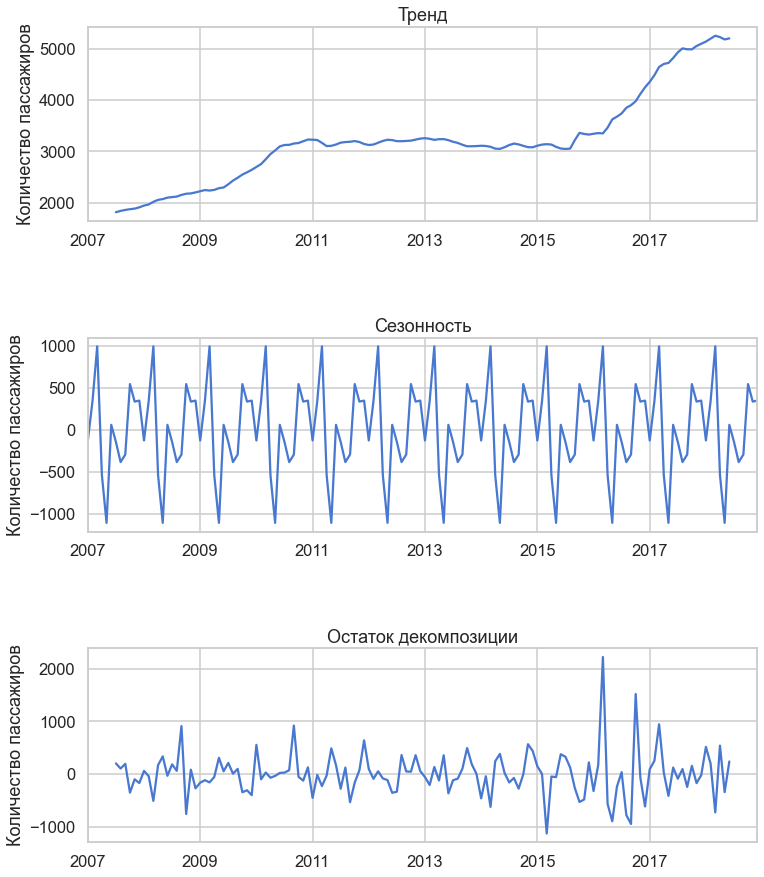

In [20]:
decomposed = seasonal_decompose(df_2018)
f, ax = plt.subplots(3, gridspec_kw={'hspace': 0.6})
f.set_figheight(15)
f.set_figwidth(12)

decomposed.trend.plot(ax=ax[0])
decomposed.seasonal.plot(ax=ax[1])
decomposed.resid.plot(ax=ax[2])

ax[0].set_title('Тренд')
ax[1].set_title('Сезонность')
ax[2].set_title('Остаток декомпозиции')

for i in range(3):
    ax[i].set(xlabel='', ylabel='Количество пассажиров')
plt.show()

Сравним среднее rolling-а по году с трендом

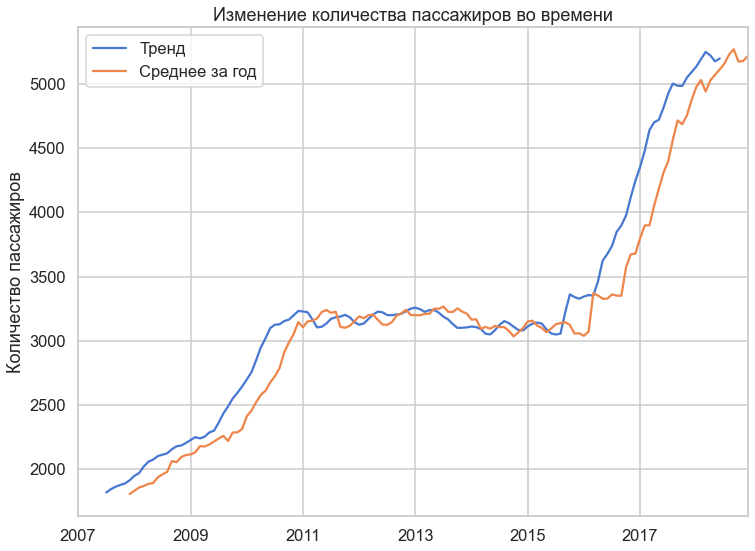

In [21]:

plt.figure(figsize=(12, 9))

ax = decomposed.trend.plot(ax=plt.gca())
df_2018.rolling(12).mean().plot(ax=ax)

plt.title('Изменение количества пассажиров во времени')
plt.xlabel('')
plt.ylabel('Количество пассажиров')
plt.legend(labels = ('Тренд', 'Среднее за год'))
plt.show()

Графики практически совпадают. Хороший признак для модели.

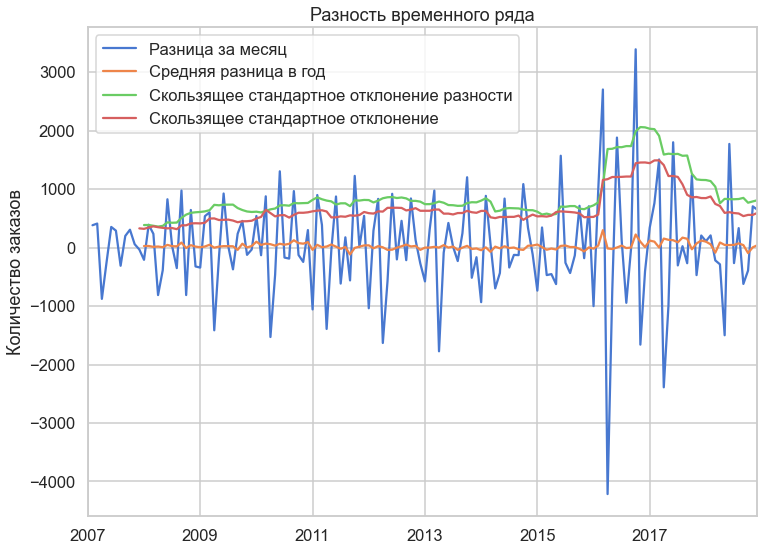

In [22]:
plt.figure(figsize=(12, 9))

ax = (df_2018 - df_2018.shift()).plot(ax=plt.gca())
(df_2018 - df_2018.shift()).rolling(12).mean().plot(ax=ax)
(df_2018 - df_2018.shift()).rolling(12).std().plot(ax=ax)
df_2018.rolling(12).std().plot(ax=ax)

plt.title('Разность временного ряда')
plt.xlabel('')
plt.ylabel('Количество заказов')
plt.legend(labels = (
    'Разница за месяц', 
    'Средняя разница в год', 
    'Скользящее стандартное отклонение разности',
    'Скользящее стандартное отклонение'
))
plt.show()

In [24]:
df_2018['month'] = df_2018.index.month
df_2018['quarter'] = df_2018.index.quarter
df_2018['year'] = df_2018.index.year
df_2018['prev_value'] = df_2018['Passengers'].shift()
df_2018['mean_12m'] = df_2018['Passengers'].shift().rolling(12).mean()
df_2018 = df_2018.dropna()
df_2018

,Passengers,month,quarter,year,prev_value,mean_12m
date,,,,,,
2008-01-01,1879.34,1,1,2008,2089.80,1807.405833
2008-02-01,2268.75,2,1,2008,1879.34,1832.745000
2008-03-01,2502.84,3,1,2008,2268.75,1858.795000
2008-04-01,1689.85,4,2,2008,2502.84,1870.235000
2008-05-01,1301.87,5,2,2008,1689.85,1887.095000
...,...,...,...,...,...,...
2018-08-01,5558.45,8,3,2018,5226.89,5157.178333
2018-09-01,4936.49,9,3,2018,5558.45,5227.800833
2018-10-01,4542.83,10,4,2018,4936.49,5268.947500


In [26]:
X, X_test, y, y_test = train_test_split(
    df_2018.drop('Passengers', axis=1), df_2018['Passengers'], shuffle=False, test_size=0.1)

In [27]:
def getModelScore(model, X,y,X_val, y_val):
    model.fit(X, y)
    predict=model.predict(X_val)
    score=mean_squared_error(y_val, predict)**0.5
    print('Ошибка модели:',score)
    return score, predict

In [28]:
rfr=RandomForestRegressor(random_state=111, n_estimators=10)
getModelScore(rfr, X,y,X_test, y_test)

Ошибка модели: 566.1349341317466


(566.1349341317466,
 array([5294.045, 5253.471, 5343.21 , 5343.21 , 5990.378, 4877.956,
        4877.956, 4308.941, 5071.464, 5071.464, 5071.464, 5253.471,
        5449.642, 5294.045]))

Предсказание

In [29]:
rfr.fit(df_2018.drop('Passengers', axis=1), df_2018['Passengers'])

RandomForestRegressor(n_estimators=10, random_state=111)

In [72]:
df_2019=df[df['Year']==2019].copy()
df_2019 = df_2019[['Passengers']]

In [73]:
df_2019['month'] = df_2019.index.month
df_2019['quarter'] = df_2019.index.quarter
df_2019['year'] = df_2019.index.year
df_2019['prev_value'] = df_2019['Passengers'].shift()
df_2019['mean_12m'] = df_2019['Passengers'].shift().rolling(12).mean()
df_2019

,Passengers,month,quarter,year,prev_value,mean_12m
date,,,,,,
2019-01-01,NaN,1,1,2019,NaN,NaN
2019-02-01,NaN,2,1,2019,NaN,NaN
2019-03-01,NaN,3,1,2019,NaN,NaN
2019-04-01,NaN,4,2,2019,NaN,NaN
2019-05-01,2876.41,5,2,2019,NaN,NaN
2019-06-01,NaN,6,2,2019,2876.41,NaN
2019-07-01,NaN,7,3,2019,NaN,NaN
2019-08-01,NaN,8,3,2019,NaN,NaN
2019-09-01,NaN,9,3,2019,NaN,NaN


In [80]:
df_p=df_2018.copy()
for row in range(0,12):
    df_p=df_p.append(df_2019.loc[df_2019.index[row]])
    df_p['prev_value'] = df_p['Passengers'].shift()
    df_p['mean_12m'] = df_p['Passengers'].shift().rolling(12).mean()
    to_predict=df_p.tail(1).drop(columns='Passengers')
    df_p.loc[df_p.index[-1],'Passengers']=rfr.predict(to_predict)

In [84]:
df_p.tail(12)['Passengers'].values

array([5290.881, 5513.344, 5383.86 , 5335.677, 4757.061, 5220.277,
       5212.219, 5212.219, 5363.159, 5505.595, 5273.241, 5574.611])

In [88]:
import json
from json import JSONEncoder
import numpy
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, numpy.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)
numpyData = {"answer": df_p.tail(12)['Passengers'].values}
encodedNumpyData = json.dumps(numpyData, cls=NumpyArrayEncoder) 
print("Printing JSON serialized NumPy array")
print(encodedNumpyData)

Printing JSON serialized NumPy array
{"answer": [5290.880999999999, 5513.344, 5383.859999999999, 5335.676999999999, 4757.061, 5220.276999999999, 5212.218999999999, 5212.218999999999, 5363.159000000001, 5505.594999999999, 5273.240999999999, 5574.610999999999]}
